In [40]:
from sparc import load_model
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
import librosa

In [41]:
import scipy.signal as signal

def modify_noise_len(clean_audio, noise):
    # Truncate or loop noise to match length of clean audio
    clean_len = clean_audio.shape[0]
    noise_len = noise.shape[0]
    if clean_len < noise_len:
        # TODO: could also get a random segment of the noise
        noise = noise[:clean_len]
    elif clean_len > noise_len:
        n_loops = clean_len // noise_len + 1
        # Apply Tukey window to avoid popping
        tukey = torch.from_numpy(signal.windows.tukey(noise_len))
        noise = noise * tukey
        noise = noise.tile((n_loops,))[:clean_len]
        
    return noise

In [ ]:
# Augment data
clean_path = "./data/train_data/_6bNvy6IFAs_0.mp4"
noise_path = "./data/noise/noise-free-sound-0000.wav"   # noise condition may be too easy
sr = 16000
snr_db = 3  # TODO: use list of a range of SNRs

clean_audio, _ = librosa.load(clean_path, sr=sr, mono=True)
noise, _ = librosa.load(noise_path, sr=sr, mono=True)
noise = modify_noise_len(clean_audio, noise)

clean_audio = torch.from_numpy(clean_audio.reshape((1, clean_audio.shape[0])))
noise = torch.from_numpy(noise.reshape((1, noise.shape[0])))
noisy_audio = torchaudio.functional.add_noise(clean_audio, noise, torch.Tensor([snr_db]))

clean_audio = clean_audio.numpy().flatten()
noisy_audio = noisy_audio.numpy().flatten()

ipd.Audio(noisy_audio, rate=sr)

76528 76528
(76528,) (76528,)


/var/folders/6_/5yzfh2mx1vn_x4wfls35qhh80000gn/T/ipykernel_38899/2153439831.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  clean_audio, _ = librosa.load(clean_path, sr=sr, mono=True)
/Users/monicatang/opt/anaconda3/envs/avatar/lib/python3.8/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [43]:
coder = load_model("multi", device= "cpu", use_penn=False)
clean_code = coder.encode(clean_audio)
noisy_code = coder.encode(noisy_audio)

/Users/monicatang/opt/anaconda3/envs/avatar/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/Users/monicatang/opt/anaconda3/envs/avatar/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [44]:
import matplotlib
color_code = {"UL":matplotlib.colors.to_rgb("#EE3A5B"),
              "LL":matplotlib.colors.to_rgb("#FFD155"),
              "LI":matplotlib.colors.to_rgb("#959595"),
              "TT":matplotlib.colors.to_rgb("#43B962"),
              "TB":matplotlib.colors.to_rgb("#C44B9F"),
              "TD":matplotlib.colors.to_rgb("#0093B7"),
              "Loudness":matplotlib.colors.to_rgb("#FB754D"),
              "Pitch":matplotlib.colors.to_rgb("#FB754D"),}

def plot_art(ax, art, gap=5, skip_y=False,color=None,alpha=1.0, lw=2):
    yticks=[]
    ytick_labels=[]
    labels = ["UL","LL", "LI", "TT", "TB", "TD"]
    chidxs = []
    HPRC_channel_label = ['LIX','LIY','ULX','ULY','LLX','LLY','TTX','TTY','TBX','TBY','TDX','TDY']
    channel_label = HPRC_channel_label
    for l in labels:
        chidxs.append(HPRC_channel_label.index(l+"X"))
        chidxs.append(HPRC_channel_label.index(l+"Y"))


    for i,ch_i in enumerate(chidxs):
        ch_label = channel_label[ch_i]
        ytick_labels.append(ch_label)
        if ch_i < 12:
            art_name= ch_label[:2]
            if color is None:
                color = color_code[art_name]
            ax.plot(art[:,ch_i]-gap*i,color=color,alpha=alpha,lw=lw)
        else:
            art_name= ch_label
            if color is None:
                color = color_code[art_name]
            ax.plot(art[:,ch_i]-gap*i,color=color,alpha=alpha,lw=lw)
        yticks.append(-gap*i)
    if skip_y:
        ytick_labels = [""]*len(ytick_labels)

    ax.set_yticks(yticks,ytick_labels,fontsize=15)

    xticks= np.arange(0,len(art),50)
    xtick_labels= [f"{int(x*20/1000)}" for x in xticks]
    ax.set_xticks(xticks, xtick_labels,fontsize=15)
    ax.set_xlabel("Time (s)", fontsize=15)
    ax.set_xlim(0,len(art))
    return yticks

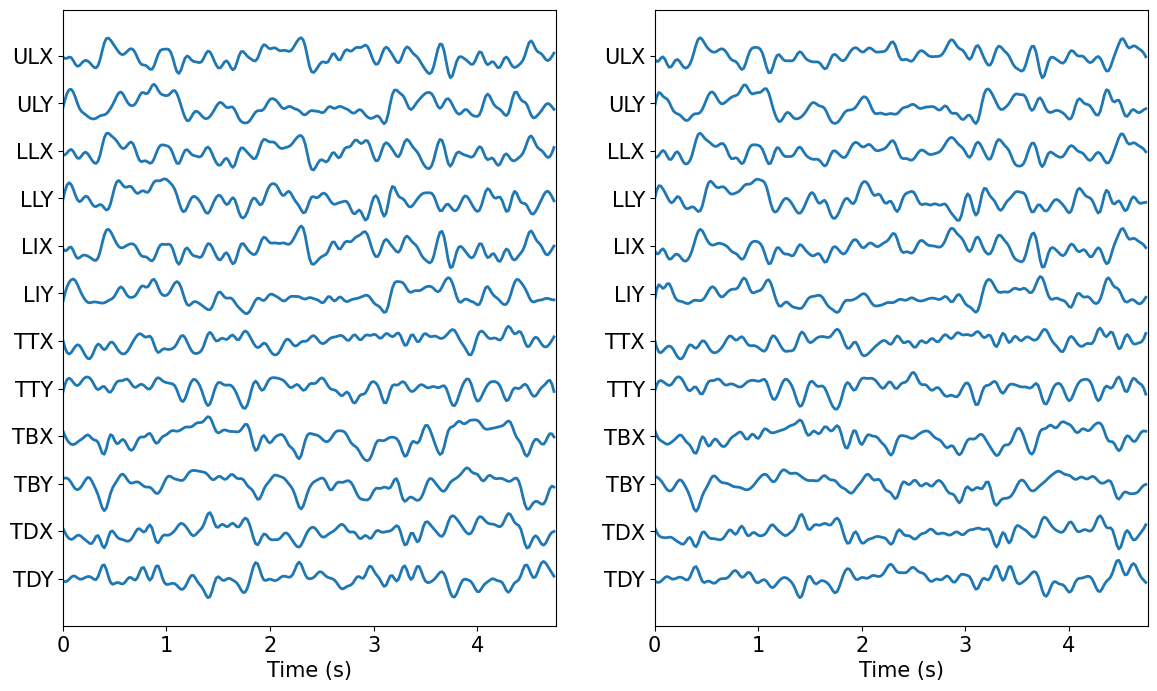

In [45]:
fig, ax = plt.subplots(1,2, figsize=(14,8))
plot_art(ax[0], clean_code['ema'][:400], color='C0', gap=6, alpha=1, lw=2)
plot_art(ax[1], noisy_code['ema'][:400], color='C0', gap=6, alpha=1, lw=2)
plt.show()

In [46]:
clean_resynth = coder.decode(**clean_code)
noisy_resynth = coder.decode(**noisy_code)

ipd.display(ipd.Audio(clean_resynth, rate=sr))
ipd.display(ipd.Audio(noisy_resynth, rate=sr))